# Trabajo Práctico Especial - Señales y Sistemas (66.74)
*Martín Cura (95874)  -   Junio 2019*

In [1]:
import numpy as np
import scipy.signal as sp_signal
import scipy.fftpack as sp_fft
import scipy.io as sp_io
import scipy.ndimage as sc_ndimage
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

In [2]:
# Parámetros
nu     = 108 # m/s    (velocidad de la plataforma)
f_s    = 50 # MHz     (frecuencia de muestreo en rango)
prf    = 125 # Hz     (pulse repetition frequency)
f_p    = 1300 # MHz   (frecuencia de la portadora)
T_rg   = 10 # us      (longitud del chirp emitido)
bw_rg  = 38 # MHz     (ancho de banda del chirp emitido)
lamb   = 0.23 # m     (longitud de onda)
r_0    = 7545 # m     (rango central)
eta_az = 0.107 # rad  (apertura angular de la antena en acimut)

## Ejercicio 1

Tenemos un *chirp* cuya frecuencia aumenta de $-BW_{rg}/2$ a $BW_{rg}/2$ entre $0$ y $T = T_{rg}$. Por la derivada dada sabemos que
$$f_{inst}(t) = 2 k_1 t + k_2$$
y reemplazando obtenemos
$$f_{inst}(0) = k_2 = -BW_{rg}/2$$
y
$$f_{inst}(T_{rg}) = 2 k_1 T_{rg} - BW_{rg}/2 = BW_{rg}/2 \implies k_1 = \frac{BW_{rg}}{2 T_{rg}}$$
con lo que solo nos falta usar los valores provistos en el apéndice.

In [3]:
k_2 = -bw_rg / 2
k_1 = bw_rg / (2 * T_rg)

Con lo que tenemos: $k_1 =$ {{ k_1 }} MHz${}^2$, $k_2 =$ {{ k_2 }} MHz, $T =$ {{ T_rg }} $\mu s$.

## Ejercicio 2

Generamos el dominio discreto donde existen las muestras:

In [4]:
t = np.linspace(0, T_rg, f_s * T_rg, endpoint=False)
t.shape

(500,)

Para calcular cada parte compleja del *chirp* aprovechamos la función en el paquete [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.chirp.html).

In [5]:
chirp_re =      sp_signal.chirp(t, f0=-bw_rg/2, f1=bw_rg/2, t1=T_rg)
chirp_im = 1j * sp_signal.chirp(t, f0=-bw_rg/2, f1=bw_rg/2, t1=T_rg, phi=-90)
chirp = chirp_re + chirp_im
chirp_ph = lambda x: k_1 * x**2 + k_2 * x + phi_0

No hay condiciones sobre $\phi_0$ por lo que tomaremos $0$ como valor arbitrario:

In [6]:
phi_0 = 0

Graficamos:

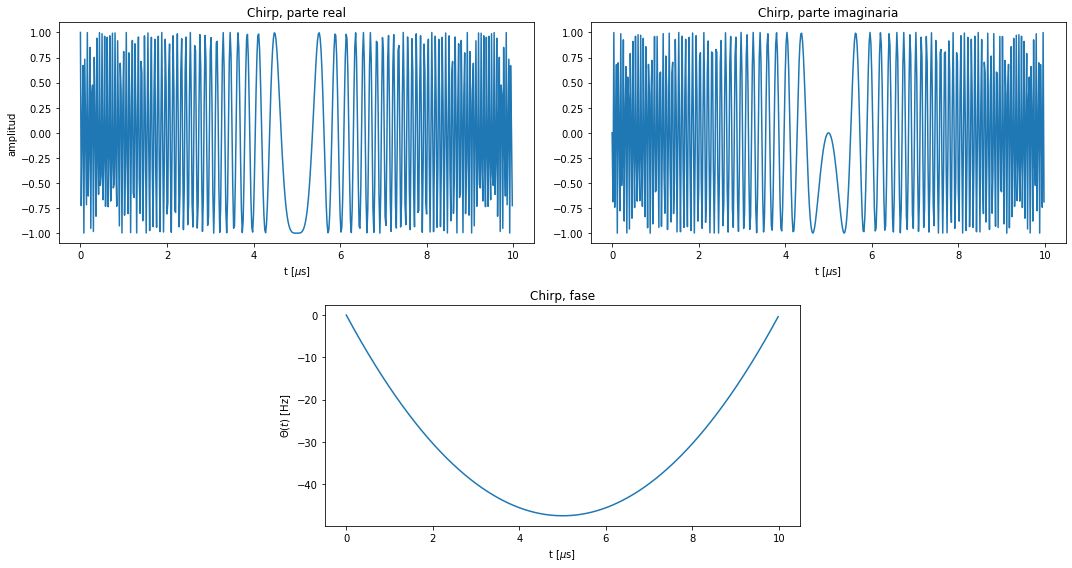

In [7]:
gs = gridspec.GridSpec(2, 4)
fig = plt.figure(figsize=(15,8))

plt.subplot(gs[0, :2], )
plt.plot(t, chirp_re)
plt.title("Chirp, parte real")
plt.xlabel("t [$\mu$s]")
plt.ylabel("amplitud")

plt.subplot(gs[0, 2:])
plt.plot(t, np.imag(chirp_im))
plt.title("Chirp, parte imaginaria")
plt.xlabel("t [$\mu$s]")

plt.subplot(gs[1, 1:3])
plt.plot(t, [chirp_ph(x) for x in t])
plt.title("Chirp, fase")
plt.xlabel("t [$\mu$s]")
plt.ylabel("$\Theta(t)$ [Hz]")

fig.tight_layout()

Para calcular la DFT usamos las funciones de [`scipy.fftpack`](https://docs.scipy.org/doc/scipy/reference/fftpack.html):

In [8]:
spect = sp_fft.fft(chirp)
freqs = sp_fft.fftfreq(len(spect), 1 / f_s)

Obtenemos el módulo del espectro en escala logarítmica mediante $\log_{10}|DFT|$ y lo graficamos:

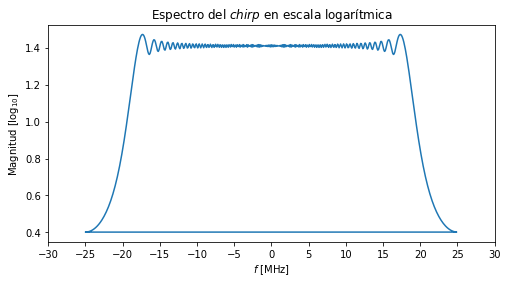

In [9]:
plt.figure(figsize=(8,4))
plt.plot(freqs, np.log10(np.abs(spect)))
plt.title("Espectro del $chirp$ en escala logarítmica")
plt.xticks(np.linspace(-30, 30, 60 // 5 + 1))
plt.xlabel("$f$ [MHz]")
plt.ylabel("Magnitud [log${}_{10}$]");

## Ejercicio 3

Por el teorema de muestreo, sabemos que el límite de Nyquist, punto mínimo teórico donde empieza a haber aliasing, es $\omega_s = 2 \omega_M$ (donde $\omega_M$ es la frecuencia de corte de la señal de banda limitada), con lo que aquí será: $2 \omega_M = BW_{rg} = 38$ MHz.

Para el espectrograma nuevamente aprovechamos lo provisto por [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html). Primero lo hacemos con la señal ya generada, cuya frecuencia de muestreo es mayor al límite de Nyquist:

In [10]:
freqs, times, spect = sp_signal.spectrogram(chirp, fs=f_s, nperseg=50, noverlap=20, window='boxcar', return_onesided=False)
freqs = sp_fft.fftshift(freqs)
spect = sp_fft.fftshift(spect, axes=0)

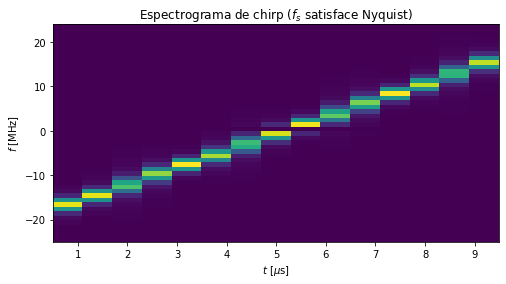

In [11]:
plt.figure(figsize=(8,4))
plt.pcolormesh(times, freqs, spect)
plt.title('Espectrograma de chirp ($f_s$ satisface Nyquist)')
plt.xlabel('$t$ [$\mu$s]')
plt.ylabel('$f$ [MHz]');

Ahora volvemos a crear un *chirp* pero esta vez con una frecuencia de muestreo menor al límite de Nyquist.

In [12]:
f_s_sN = 30  # frecuencia "subNyquist"
t_sN = np.linspace(0, T_rg, f_s_sN * T_rg, endpoint=False)
chirp_re_sN =      sp_signal.chirp(t_sN, f0=-bw_rg/2, f1=bw_rg/2, t1=T_rg)
chirp_im_sN = 1j * sp_signal.chirp(t_sN, f0=-bw_rg/2, f1=bw_rg/2, t1=T_rg, phi=-90)
chirp_sN = chirp_re_sN + chirp_im_sN

In [13]:
freqs_sN, times_sN, spect_sN = sp_signal.spectrogram(chirp_sN, fs=f_s, nperseg=50, noverlap=20, window='boxcar', return_onesided=False)
freqs_sN = sp_fft.fftshift(freqs_sN)
spect_sN = sp_fft.fftshift(spect_sN, axes=0)

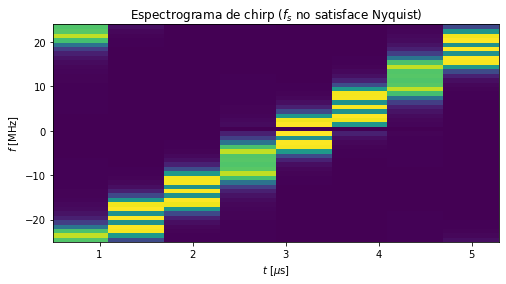

In [14]:
plt.figure(figsize=(8,4))
plt.pcolormesh(times_sN, freqs_sN, spect_sN)
plt.title('Espectrograma de chirp ($f_s$ no satisface Nyquist)')
plt.xlabel('$t$ [$\mu$s]')
plt.ylabel('$f$ [MHz]');

Al graficar nuevamente el espectrograma es notable el efecto de *aliasing* observando la superposición entre las muestras contiguas.

## Ejercicio 4

Representando la atenuación de forma lineal, se puede esquematizar cada paso entre transformaciones como en el siguiente diagrama:

![TPE-ej4.png](TPE-ej4.png)

## Ejercicio 5

Realizamos algo similar al ejercicio anterior pero con el proceso de recepción de los ecos (ignorando el ruido que pueda llegar al sensor):

![TPE-ej5.png](TPE-ej5.png)

## Ejercicio 6

Para ver la relación, graficamos los espectros de la parte real y de la parte imaginaria del *chirp*:

In [15]:
spect_re = sp_fft.fft(np.real(chirp))
spect_im = sp_fft.fft(np.imag(chirp))
freqs_re = sp_fft.fftfreq(len(spect_re), 1 / f_s)
freqs_im = sp_fft.fftfreq(len(spect_im), 1 / f_s)

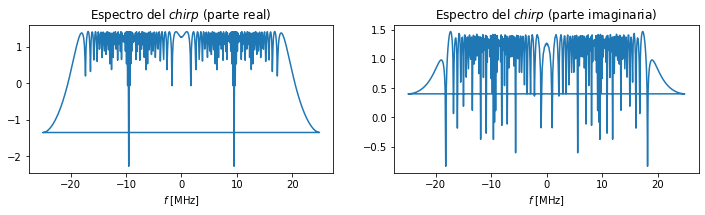

In [16]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(221)
plt.plot(freqs_re, np.log10(np.abs(spect_re)))
plt.xlabel('$f$ [MHz]')
plt.title("Espectro del $chirp$ (parte real)");
fig.add_subplot(222)
plt.plot(freqs_im, np.log10(np.abs(spect_im)))
plt.xlabel('$f$ [MHz]')
plt.title("Espectro del $chirp$ (parte imaginaria)");

Descontando las oscilaciones y picos muy rápidos que se generan por el fenómeno de Gibbs, se puede reconocer $I(n)$ y $Q(n)$ (del ejercicio anterior) en las figuras.

## Ejercicio 7

La operación de correlación se ve muy similar a la de convolución. Desarrollando la expresión dada:
$$ C_{xy}(n) = x(n) \star y(n) = \sum_{k} x^*(k) y(k+n) = [x^*(n)] \ast [y(-n)] \neq C_{yx}(n) $$
Con esto vemos que la operación no es conmutativa. Esto último también nos permite expresar la correlación en términos de transformadas de Fourier:
$$ C_{xy} = \mathcal{F}^{-1}[\mathcal{F}^*[x] \mathcal{F}[y]] $$

## Ejercicio 8

Calculamos la autocorrelación del *chirp* usando la expresión del ejercicio anterior y graficamos:

In [17]:
chirp_autocorr = np.convolve(np.conj(chirp), chirp[::-1])

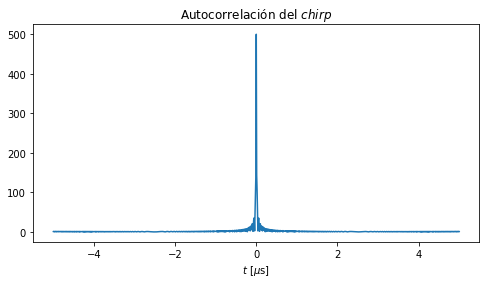

In [18]:
plt.figure(figsize=(8,4))
plt.plot(np.linspace(-T_rg/2, T_rg/2, chirp_autocorr.size), np.abs(chirp_autocorr))
plt.title("Autocorrelación del $chirp$")
plt.xlabel('$t$ [$\mu$s]');

El factor de compresión es aproximadamente de $T \cdot BW = 380$.

## Ejercicio 9

Repetimos la autocorrelación pero mediante DFT. Antes de realizar la cuenta nos aseguramos de que el resultado salga como queremos agregando *padding* de cada lado en las copias del *chirp*.

In [19]:
chirp_a = np.pad(chirp, (0, len(chirp) - 1), mode='constant')
chirp_b = np.pad(chirp, (len(chirp) - 1, 0), mode='constant')
# Ver ecuación en el Ejercicio 7
chirp_autocorr_2 = sp_fft.ifft(np.conj(sp_fft.fft(chirp_a)) * sp_fft.fft(chirp_b))

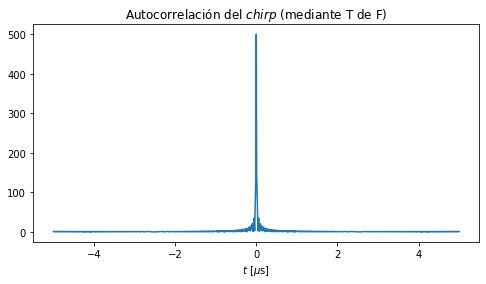

In [20]:
plt.figure(figsize=(8,4))
plt.plot(np.linspace(-T_rg/2, T_rg/2, chirp_autocorr_2.size), np.abs(chirp_autocorr_2))
# plt.plot(np.abs(chirp_autocorr_2))
plt.title("Autocorrelación del $chirp$ (mediante T de F)")
plt.xlabel('$t$ [$\mu$s]');

## Ejercicio 10

Cargamos la matriz de la imagen sintética desde el archivo provisto:

In [21]:
sint_mat = sp_io.loadmat('SAR_data_sint.mat')['data_sint']

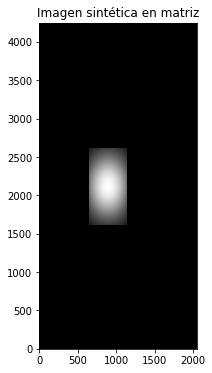

In [22]:
plt.rcParams["figure.figsize"][1] = 6
plt.figure().add_subplot(111).set_aspect('equal', 'box')
plt.pcolormesh(abs(sint_mat), cmap=cm.gray)
plt.title("Imagen sintética en matriz");

Ahora aplicamos el enfocado en rango, realizando la correlación de cada fila de la matriz con el *chirp* emitido:

In [23]:
def correlation(x, y):
    x = np.pad(x, (0, len(y) - len(x)), mode='constant')
    return sp_fft.ifft(np.conj(sp_fft.fft(x)) * sp_fft.fft(y))

def range_compression(mat, chirp_signal):
    return np.array([correlation(chirp_signal, row) for row in mat])

In [24]:
sint_range_compressed = range_compression(sint_mat, chirp)

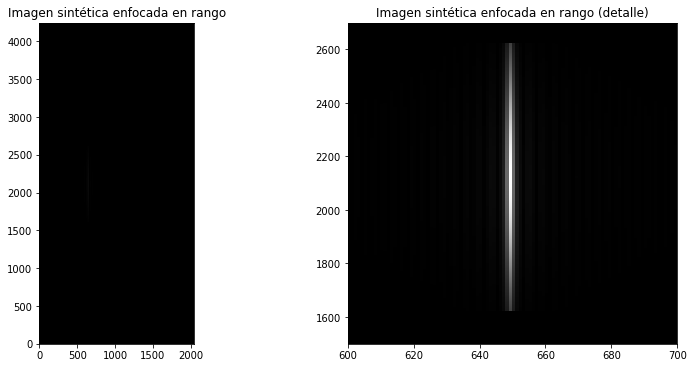

In [25]:
fig = plt.figure(figsize=(13,13))
fig.add_subplot(221).set_aspect('equal', 'box')
plt.pcolormesh(abs(sint_range_compressed), cmap=cm.gray)
plt.title("Imagen sintética enfocada en rango");
ax = fig.add_subplot(222)
plt.axis([600, 700, 1500, 2700])
plt.pcolormesh(abs(sint_range_compressed), cmap=cm.gray)
plt.title("Imagen sintética enfocada en rango (detalle)");

Es bastante tenue pero se puede apreciar una línea borroneada por la columna 650. Ahora hacemos un proceso similar para la imagen captada por SARAT. Para graficar usamos el logaritmo y transponemos por comodidad.

In [26]:
sarat_mat = sp_io.loadmat('SAR_data_sarat.mat')['data']

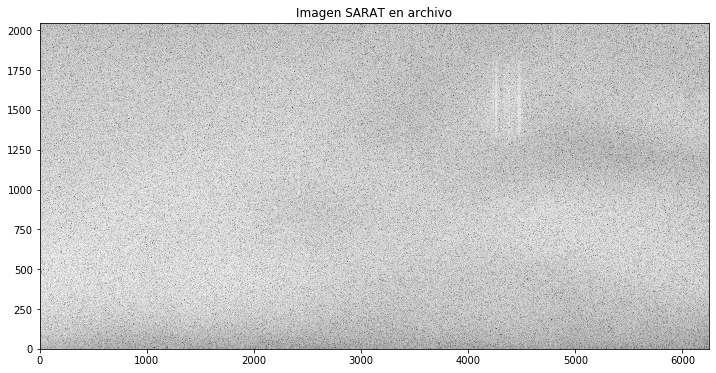

In [27]:
plt.figure(figsize=(12, 6)).add_subplot(111)
plt.pcolormesh(np.log10(np.abs(np.transpose(sarat_mat))), cmap=cm.gray)
plt.title("Imagen SARAT en archivo");

In [28]:
sarat_range_compressed = range_compression(sarat_mat, chirp)

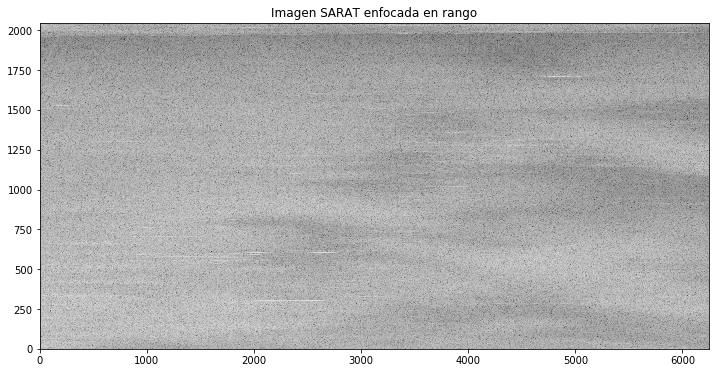

In [29]:
plt.figure(figsize=(12, 6)).add_subplot(111)
plt.pcolormesh(np.log10(np.abs(np.transpose(sarat_range_compressed))), cmap=cm.gray)
plt.title("Imagen SARAT enfocada en rango");

Se empieza a apreciar formas en la imagen, pero todavía quedará enfocar en el eje de acimut.

## Ejercicio 11

Usamos las ecuaciones y constantes dadas para calcular la duración temporal del nuevo *chirp*:

In [ ]:
T_az = eta_az * r_0 / nu

Con lo que tenemos $T_{az} =$ {{ round(T_az, 4) }} $\mu$s.

Para el ancho de banda, tal como hicimos al principio del trabajo, derivamos la fase y aplicamos entre $-T_{az}/2$ y $T_{az}/2$:
$$ f_{az}(t) = -2 \frac{\nu^2}{\lambda r_0} t $$

In [ ]:
frec_az = lambda x: -2 * nu**2 * x / (lamb * r_0)
bw_az = abs(frec_az(-T_az/2) - frec_az(T_az/2))

Con lo que tenemos $BW_{az} =$ {{ round(bw_az, 4) }} Hz.

## Ejercicio 12

In [32]:
t_az = np.linspace(-T_az/2, T_az/2, int(prf * T_az), endpoint=False)

k_1 = -nu**2 / (lamb * r_0)
k_2 = 0
chirp_az_ph = lambda x: k_1 * x**2 + k_2 * x + phi_0

chirp_az = np.array([np.exp(2j * np.pi * chirp_az_ph(x)) for x in t_az])
## Forma alternativa:
# f0_az = frec_az(-T_az/2)
# f1_az = frec_az( T_az/2)
# chirp_az_re =      sp_signal.chirp(t_az, f0=f0_az, f1=f1_az, t1=T_az)
# chirp_az_im = 1j * sp_signal.chirp(t_az, f0=f0_az, f1=f1_az, t1=T_az, phi=-90)
# chirp_az = chirp_az_re + chirp_az_im

Nuevamente podemos graficar la función de fase y verificamos que ahora varía en forma descendente:

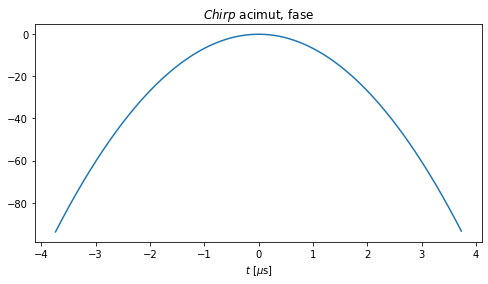

In [33]:
plt.figure(figsize=(8,4))
plt.plot(t_az, [chirp_az_ph(x) for x in t_az])
plt.title("$Chirp$ acimut, fase")
plt.xlabel('$t$ [$\mu$s]');

Veremos el mismo cambio de sentido al graficar el espectograma para este nuevo *chirp* que usaremos en la línea del acimut:

In [34]:
freqs_az, times_az, spect_az = sp_signal.spectrogram(chirp_az, fs=prf, nperseg=50, noverlap=20, window='boxcar', return_onesided=False)
freqs_az = sp_fft.fftshift(freqs_az)
spect_az = sp_fft.fftshift(spect_az, axes=0)

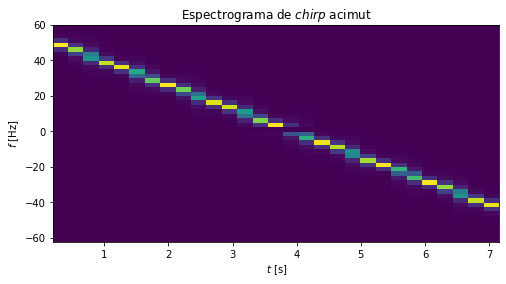

In [35]:
plt.figure(figsize=(8,4))
plt.pcolormesh(times_az, freqs_az, spect_az)
plt.title('Espectrograma de $chirp$ acimut')
plt.xlabel('$t$ [s]')
plt.ylabel('$f$ [Hz]');

## Ejercicio 13

Ahora enfocamos en acimut, esto es, sobre las imágenes ya comprimidas en sentido del rango volvemos a aplicar el algoritmo de compresión pero en acimut.

In [36]:
def acimut_compression(mat, chirp_signal):
    return np.transpose([correlation(chirp_signal, col) for col in np.transpose(mat)])

Primero lo hacemos con la imagen sintética:

In [37]:
sint_focused = acimut_compression(sint_range_compressed, chirp_az)

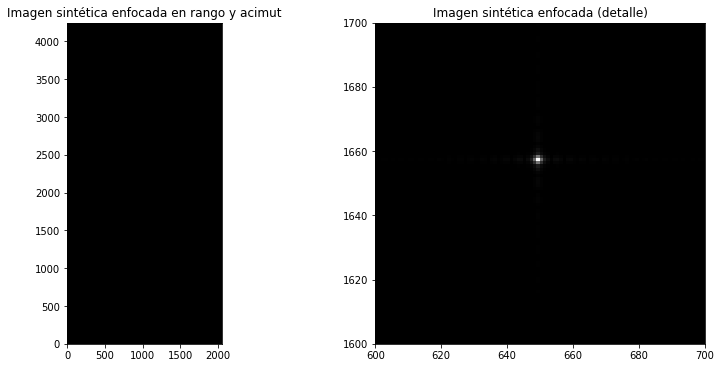

In [38]:
fig = plt.figure(figsize=(13,13))
fig.add_subplot(221).set_aspect('equal', 'box')
plt.pcolormesh(abs(sint_focused), cmap=cm.gray)
plt.title("Imagen sintética enfocada en rango y acimut");
ax = fig.add_subplot(222)
plt.axis([600, 700, 1600, 1700])
plt.pcolormesh(abs(sint_focused), cmap=cm.gray)
plt.title("Imagen sintética enfocada (detalle)");

Ahora lo que era una línea quedó concentrada en un punto. Probemos con la imagen capturada por SARAT:

In [39]:
sarat_focused = acimut_compression(sarat_range_compressed, chirp_az)

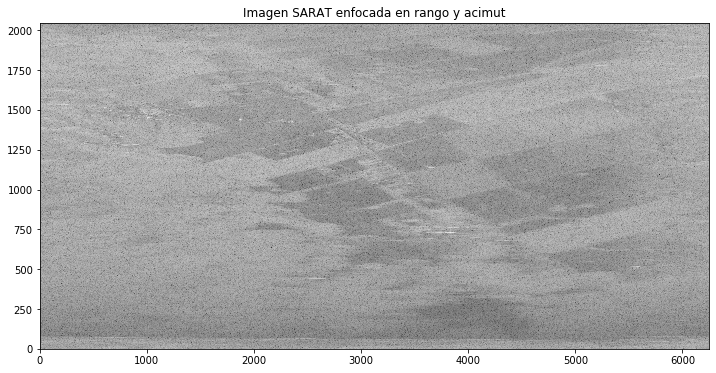

In [40]:
plt.figure(figsize=(12, 6)).add_subplot(111)
plt.pcolormesh(np.log10(np.abs(np.rot90(sarat_focused))), cmap=cm.gray)
plt.title("Imagen SARAT enfocada en rango y acimut");

¡Eureka! *Enhance...*

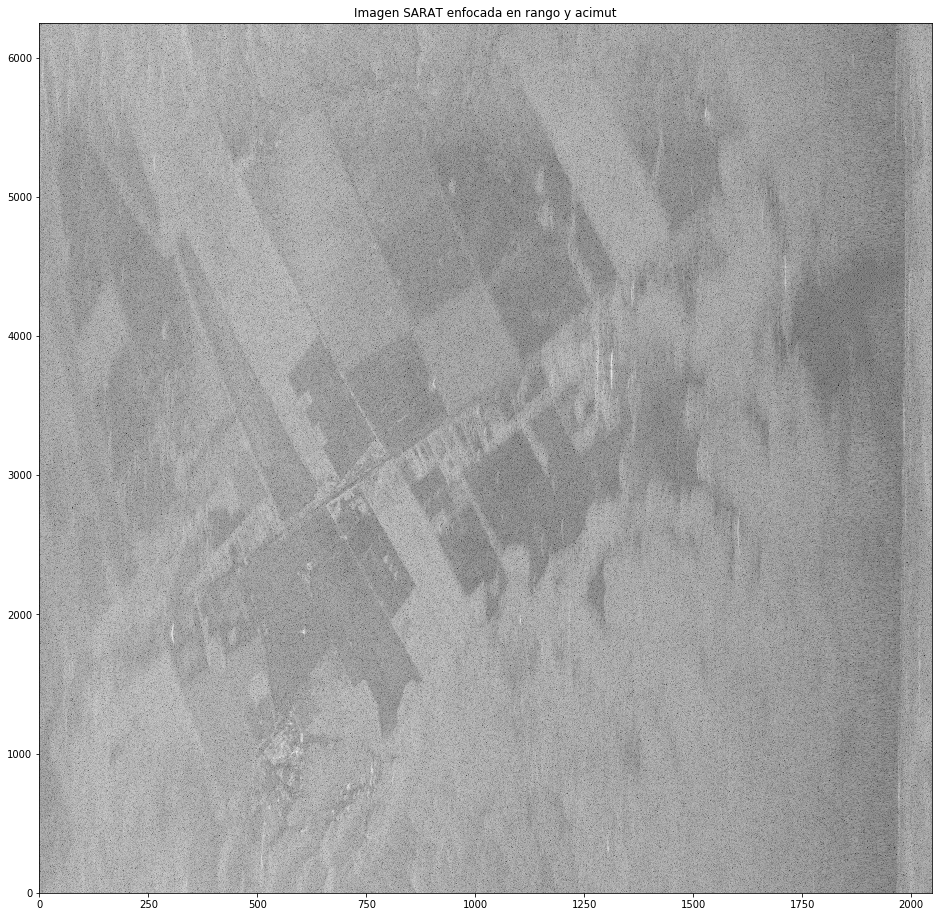

In [41]:
plt.figure(figsize=(16, 16)).add_subplot(111)
plt.pcolormesh(np.log10(np.abs(sarat_focused)), cmap=cm.gray)
plt.title("Imagen SARAT enfocada en rango y acimut");

## Ejercicio 14 *(opcional)*

Por el bonus, aplicamos un promediador móvil sobre el valor absoluto de la imagen focalizada para intentar reducir el ruido:

In [42]:
moving_average = np.ones((4, 4)) / 16
sarat_averaged = sc_ndimage.convolve(np.abs(sarat_focused), moving_average)

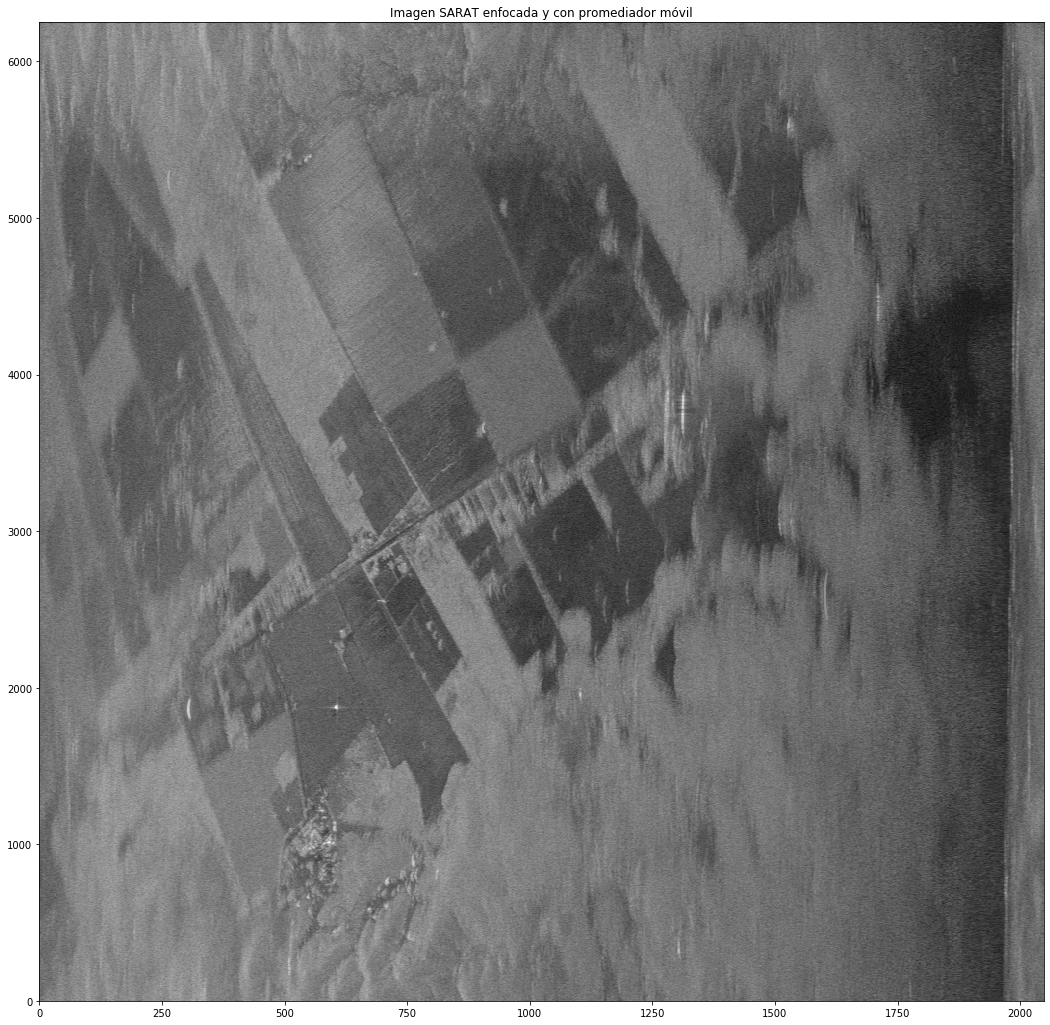

In [43]:
plt.figure(figsize=(18, 18)).add_subplot(111)
plt.pcolormesh(np.log10(np.abs(sarat_averaged)), cmap=cm.gray)
plt.title("Imagen SARAT enfocada y con promediador móvil");

## Ejercicio 15 *(opcional)*

Como gran final, rehacemos el focalizador del ejercicio 13 con un $r_0$ y consecuentemente un *chirp* especializado por columna (acimut), en base a la expresión dada.

In [44]:
def specialized_acimut_compression(mat):
    col_r_0 = lambda j: 7545 + 3 * (j - 650)
    col_k_1 = lambda j: -nu**2 / (lamb * col_r_0(j))
    col_chirp_ph = lambda x, j: col_k_1(j) * x**2 + k_2 * x + phi_0
    col_chirp = lambda j: np.array([np.exp(2j * np.pi * col_chirp_ph(x, j)) for x in t_az])

    return np.transpose([correlation(col_chirp(j), col) for j, col in enumerate(np.transpose(mat))])

In [45]:
sarat_focused_15 = specialized_acimut_compression(sarat_range_compressed)
sarat_averaged_15 = sc_ndimage.convolve(np.abs(sarat_focused_15), moving_average)

Finalmente, obtenemos un hermoso paisaje.

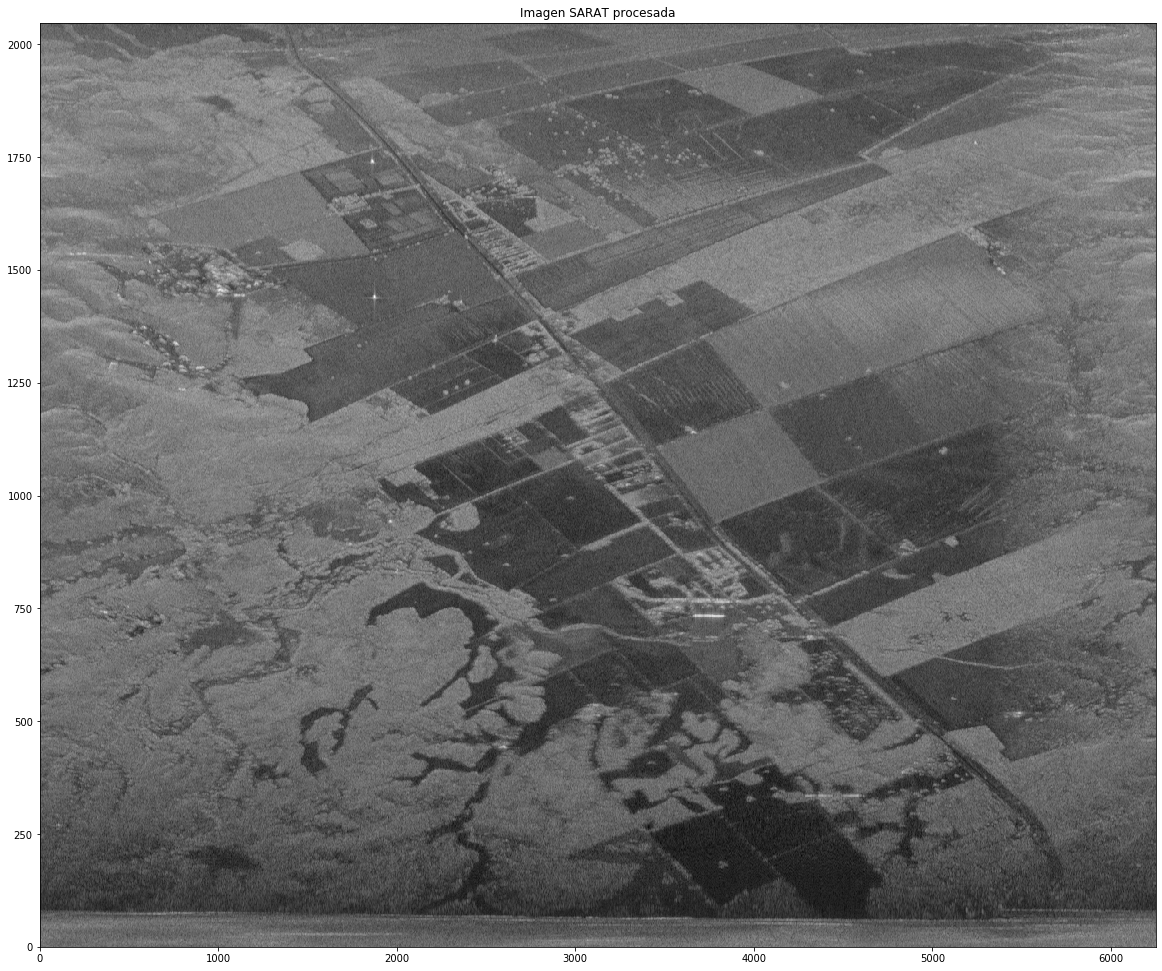

In [47]:
plt.figure(figsize=(20, 17)).add_subplot(111)
plt.pcolormesh(np.log10(np.abs(np.rot90(sarat_averaged_15))), cmap=cm.gray)
plt.title("Imagen SARAT procesada");

Orientada como en el enunciado:

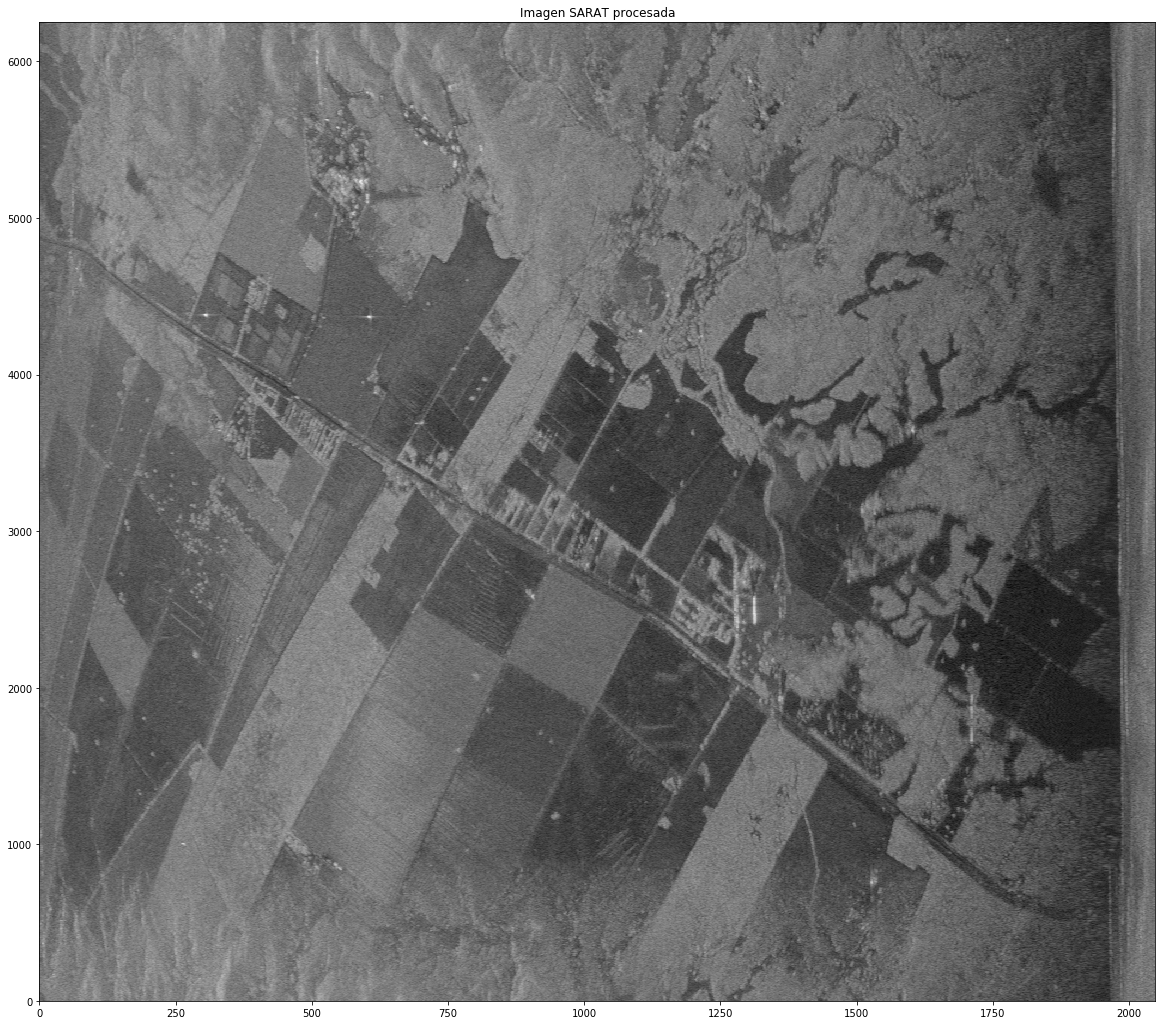

In [48]:
plt.figure(figsize=(20, 18)).add_subplot(111)
plt.pcolormesh(np.log10(np.abs(np.rot90(np.transpose(sarat_averaged_15)))), cmap=cm.gray)
plt.title("Imagen SARAT procesada");